# Crashworthiness

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from control.matlab import step, impulse, ss
from control import forced_response

def landing_gear(M1,M2,K1,K2,B):
    
    A = np.array([[0, 1, 0, 0], [-K1/M1, -B/M1, K1/M1, B/M1],[0, 0, 0, 1],[K1/M2, B/M2, -(K1+K2)/M2, -B/M2]])
    
    B = np.array([[0],[0],[0],[1/M2]])
    
    C = np.array([[1, 0, 0, 0]])
    
    D = np.array([[0]])
    
    return ss(A,B,C,D)


<AxesSubplot:>

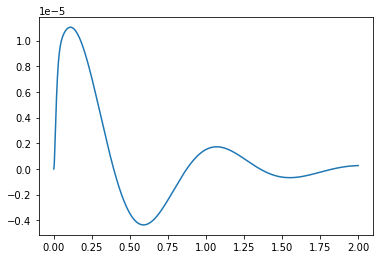

In [2]:
M1 = 1930   #airplane mass  [kg]
M2 = 50     # mass of 2 wheels (rear set)  -  research wheel mass - no data
K1 = 100000            #variable
K2 = 535323.6 # [N/m]   -   https://www.aircraftdesigns.com/design/gyroplanes/landing-gear-loads/
B = 10000   # [N/(m/s)]    #variable
# change K1 and B

sys = landing_gear(M1, M2, K1, K2, B)

#y1, t = step(H, t)       
y, t = impulse(sys, np.linspace(0, 2, 1000))
sns.lineplot(x=t, y=y)

$\vec{x} = [y_G, \alpha, \beta, \dot{y}_G, \dot{\alpha}, \dot{\beta}]^T$

$\vec{u} = [0, 0, 0, f(t), 0, 0]^T$

$\dot{\vec{x}} = A \cdot \vec{x} + B \cdot \vec{u}$

$\vec{y} = C \cdot \vec{x} + D \cdot \vec{u}$

In [3]:
import numpy as np
import control.matlab as c

def GearSystem(K, C, M, d, l1, l2):
    (k1, k2, k3), (c1, c2, c3), (m, Jx, Jz) = K, C, M

    #unknown = {'yG': [1, 0, 0]+[0]*3, 'alpha': [0, 1, 0]+[0]*3, 'beta': [0, 0, 1]+[0]*3,
    #          'yGd': [0]*3+[1, 0, 0], 'alphad': [0]*3+[0, 1, 0], 'betad': [0]*3+[0, 0, 1]}[uk]

    d3 = np.sqrt(l2 ** 2 - 0.25 * l1 ** 2) - d

    SFs = -(1/m) * np.array([k1 + k2 + k3, 0.5 * l1 * (k1 - k2), d * (k1 + k2) - d3 * k3,
                             c1 + c2 + c3, 0.5 * l1 * (c1 - c2), d * (c1 + c2) - d3 * c3])

    SMx = -(1/Jx) * np.array([0.5 * l1 * (k1 - k2), 0.25 * l1 ** 2 * (k1 + k2), (k1-k2)*d*l1*0.5,
                              0.5 * l1 * (c1 - c2), 0.25 * l1 ** 2 * (c1 + c2), (c1-c2)*d*l1*0.5])

    SMz = -(1/Jz) * np.array([d * (k1 + k2) - d3 * k3, 0.5 * l1 * d * (k1 - k2), d*d * (k1 + k2) + d3*d3 * k3,
                              d * (c1 + c2) - d3 * c3, 0.5 * l1 * d * (c1 - c2), d*d * (c1 + c2) + d3*d3 * c3])

    A = np.array([[0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1],
                   SFs, SMx, SMz])

    B = np.array([[0, 0, 0, -1/m, 0, 0]]).T

    C = np.concatenate([np.identity(len(A))[:3, :], A])

    D = np.zeros([len(A)+3, 1])
    D[6][0] = -1/m

    return c.ss(A, B, C, D)


def SolveLandingGear(sys, imp, forc, t0, t1):
    yimp, t = c.impulse(sys, np.linspace(t0, t1, 1000), 0, 0)
    yforc, t = c.step(sys, t)
    return t, yimp * imp + forc * yforc

In [4]:
M1 = 2793.79
Vcrash = 9.9 #m/s
gmax = 8.78   #6.94  # the classic g's on contact
Dtot = gmax*9.81*M1/Vcrash

gmax2 =  3.51   #2.4 #g's on fullly compressed spring
gear_displacement = 0.4  # m
Ktot = gmax2*9.81 * M1 / gear_displacement






K = [Ktot/6, Ktot/6, Ktot*2/3] # Spring constants k1, k2, k3 N/m
C = [Dtot/6, Dtot/6, Dtot*2/3] # Damping coefficients c1, c2, c3 N/ms-1
d, l1, l2 = 2.35, 1.2, (0.6*0.6+3.2*3.2)**0.5 # zcg, d landing gears, d2 landing gears [m]
M = M1, 7810.79, 15451.34 # m [kg], Jx [kgm2], Jz [kgm2]

(sys := GearSystem(K, C, M, d, l1, l2))
print(K, C)

[40082.85435375, 40082.85435375, 160331.417415] [4051.08016030303, 4051.08016030303, 16204.32064121212]


crash speed, using the full range of landing gear strut
yellow line is max allowable acceleration
final velocity [m/s] = [-6.01239217]
final gear displacement [m] = [-0.39779511]


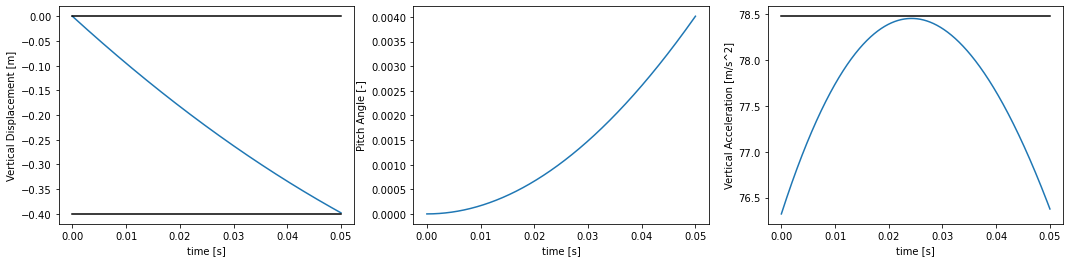

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
imp, forc = Vcrash*M1, M1*9.81 # N*s, N

tsim = 0.05


t, y = SolveLandingGear(sys, imp, forc, 0, tsim)
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
sns.lineplot(x=t, y=y[:, 0].T[0])
sns.lineplot(x=t, y=[-0.4]*len(t), color="black")
sns.lineplot(x=t, y=[0]*len(t), color="black")
plt.ylabel("Vertical Displacement [m]")
plt.xlabel("time [s]")

plt.subplot(1, 3, 2)
sns.lineplot(x=t, y=y[:, 2].T[0])
plt.ylabel("Pitch Angle [-]")
plt.xlabel("time [s]")

plt.subplot(1, 3, 3)
sns.lineplot(x=t, y=y[:, 6].T[0])
sns.lineplot(x=t, y=[78.48]*len(t), color="black" )  #8g
plt.ylabel("Vertical Acceleration [m/s^2]")
plt.xlabel("time [s]")
# y, v, a
print("crash speed, using the full range of landing gear strut")
print("yellow line is max allowable acceleration")
print("final velocity [m/s] =", max(y[:, 3]))
print("final gear displacement [m] =", min(y[:, 0]))

hard landing speed, deceleration distance < landing gear strut
acceleration should be comfortable


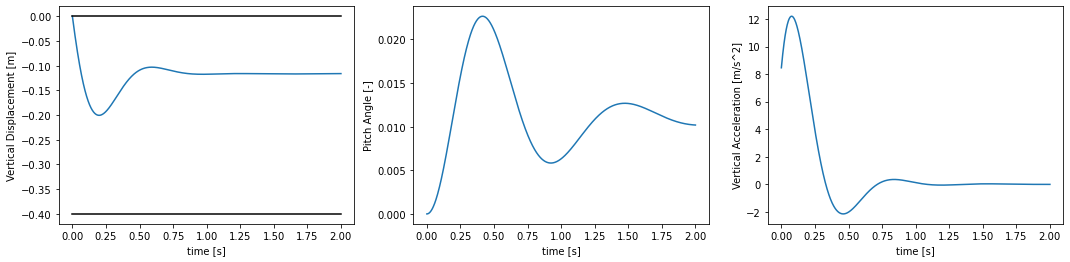

In [6]:
tsim = 2
Vland = 2.1  #2.1  #m/s
imp2 = Vland*M1


t, y = SolveLandingGear(sys, imp2, forc, 0, tsim)
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
sns.lineplot(x=t, y=y[:, 0].T[0])
sns.lineplot(x=t, y=[-0.4]*len(t), color="black")
sns.lineplot(x=t, y=[0]*len(t), color="black")
plt.ylabel("Vertical Displacement [m]")
plt.xlabel("time [s]")

plt.subplot(1, 3, 2)
sns.lineplot(x=t, y=y[:, 2].T[0])
plt.ylabel("Pitch Angle [-]")
plt.xlabel("time [s]")

plt.subplot(1, 3, 3)
sns.lineplot(x=t, y=y[:, 6].T[0])
plt.ylabel("Vertical Acceleration [m/s^2]")
plt.xlabel("time [s]")
# y, beta, a
print("hard landing speed, deceleration distance < landing gear strut")
print("acceleration should be comfortable")

In [7]:
a_max = 11*9.81
M_pld = 475
M_central_fuselage = 150 + 1000  #??? + batteries
v_0 = 6.01

L_absorb = v_0*v_0/2/a_max
print(L_absorb)

0.1673621536465573


In [8]:
p_input = 0.6 * 0.23 * 1000000 #Pa

A_req = (M_pld+M_central_fuselage)*(a_max+9.81)/p_input

print(A_req)
print("width =", A_req/3.7)

1.3861956521739132
width = 0.37464747356051703


In [9]:
(m_crash := 23*A_req*L_absorb)

5.3359238636363635

In [10]:
m_tot = 3000
a_belly = (p_input * A_req / m_tot) - 9.81

L_absorb2 = Vland*Vland/2/a_belly

print(a_belly/9.81, L_absorb2, L_absorb2/L_absorb)

5.5 0.040867389491242696 0.24418537047239625


In [11]:
#  rotation mechanism calcs

# at z = 0.8m:
Mx = 26000
My = 13000
M_tot = (Mx**2+My**2)**0.5
o_y = 468000000
chord = 1.665-1.665*0.55*0.8/4.1
Radius_tube = 0.17*chord/2

t_tube = M_tot/3.14/Radius_tube**2/o_y


print(chord, Radius_tube, t_tube)




1.4863170731707318 0.12633695121951222 0.0012393445715628267
